In [2]:
from fastai.text.all import *

In [19]:
lang = 'de'
path = Path('data/dewiki_lstm_15k')
model_path = path/'model'
data_path = Path('data')
spm_path = Path('data/spm_de_ft')
lm_ft_fns = [model_path/f'{lang}_ft', model_path/f'{lang}_ft_vocab']

In [20]:
bs = 64

## Prepare classifier dataset

In [21]:
names = ['text','label','label1,']

In [22]:
df_train = pd.read_csv(data_path/'germeval2018/germeval2018.training.txt',
                sep ='\t', names=names)

In [23]:
df_train['is_valid'] = False

In [25]:
df_valid = pd.read_csv(data_path/'germeval2018/germeval2018.test.txt',
                sep ='\t', names=names)

In [26]:
df_valid['is_valid'] = True

In [27]:
df = pd.concat([df_train, df_valid])

## Train model

In [28]:
tok = SentencePieceTokenizer(lang=lang, sp_model=spm_path/'spm.model')

In [29]:
with open(f'{lm_ft_fns[1]}.pkl', 'rb') as f:
      vocab = pickle.load(f)

In [30]:
dblocks = DataBlock(blocks=(TextBlock.from_df('text', tok=tok, vocab=vocab), CategoryBlock),
                    get_x=ColReader('text'),
                    get_y=ColReader('label'), 
                    splitter=ColSplitter())
dls = dblocks.dataloaders(df)

/home/florian/miniconda3/envs/fastai/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [31]:
dls.show_batch()

,text,category
0,"▁xxbos ▁@ machtjanix 23 ▁@ schneeridara ▁@ kr eb bi ▁@ queeniepi ▁@ vergangenheit 17 ▁@ m x lo la 5 ▁@ la z ar us 06 ▁@ lars 959 6 ▁@ heinrich heine 12 ▁@ kokolores 20 ▁@ dunkel denk ▁@ kreativ design 1 ▁@ em ili ac 32 ▁@ die ba ju waren ▁@ lawyerberlin ▁@ s bu nners ▁@ twittonium ▁@ ey svog 3 l ▁@ gun nar _ rich ert ▁@ so rt ex ▁@ loriotfehlt ▁@ nasanasal ▁@ norb inator 2403 ▁@ troll _ putin ▁@ lc 180 ▁xxrep ▁3 ▁6 ▁@ ve spasi anus 69 bc ▁@ xx 7 ni tro 1 xx ▁@ t bg steph en ▁xxmaj ▁dazu ▁braucht ▁es ▁erst ▁einmal ▁eine ▁andere ▁xxmaj ▁ bezeichnung . ▁"" rechts "" ▁ist ▁derart ▁negativ ▁ ko n not iert . ▁xxmaj ▁ich ▁persönlich ▁denke ▁sowieso ▁nicht ▁in ▁diesen ▁xxmaj ▁schublade n ,",OTHER
1,▁xxbos ▁@ dunkel denk ▁@ west hexe ▁@ so rt ex ▁@ machtjanix 23 ▁@ queeniepi ▁@ schneeridara ▁@ kr eb bi ▁@ vergangenheit 17 ▁@ m x lo la 5 ▁@ la z ar us 06 ▁@ lars 959 6 ▁@ heinrich heine 12 ▁@ kokolores 20 ▁@ kreativ design 1 ▁@ em ili ac 32 ▁@ die ba ju waren ▁@ lawyerberlin ▁@ s bu nners ▁@ twittonium ▁@ ey svog 3 l ▁@ gun nar _ rich ert ▁@ loriotfehlt ▁@ nasanasal ▁@ norb inator 2403 ▁@ troll _ putin ▁@ lc 180 ▁xxrep ▁3 ▁6 ▁@ ve spasi anus 69 bc ▁@ xx 7 ni tro 1 xx ▁@ t bg steph en ▁xxmaj ▁ich ▁finde ▁sämtliche ▁xxmaj ▁beleidigung s - ▁und ▁xxmaj ▁volksverhetzung s gesetze ▁müssen ▁weg . ▁xxmaj ▁einen ▁intelligent en ▁xxmaj ▁menschen ▁kann ▁man ▁nicht ▁beleidigen . ▁xxmaj ▁man ▁sollte ▁hingegen ▁xxmaj ▁kindern,OTHER
2,"▁xxbos ▁@ felden f rizz ▁@ wo j tek thomalla ▁@ _ macmike ▁@ nawrat anna ▁@ athin a mala ▁@ charlie _ silve ▁@ pe tpanther 0 ▁@ musta pha mond ah ▁@ sjw _ madbunny ▁@ master m ikeg ▁@ machtjanix 23 ▁@ spadecarrier ▁@ steffmann 45 ▁@ troll _ putin ▁@ norb inator 2403 ▁@ en nof _ ▁@ n ancy peg gym andy ▁@ info 2099 ▁@ life trend ▁@ thomasgbauer ▁@ schmid die maik ▁@ noherrman ▁@ will j rosen blatt ▁@ nasanasal ▁@ ellibisathide ▁@ md _ franz ▁@ youtube ▁xxmaj ▁es ▁war ▁wichtig , ▁zuerst ▁das ▁alte ▁xxmaj ▁europa ▁zu ▁zerstören , ▁da ▁sitzt ▁die ▁meist e ▁xxmaj ▁intelligenz ▁ - ▁ist ▁es ▁völlig ▁zerstört ▁und ▁mit ▁xxup ▁iq ▁90 ▁auf gefüllt , ▁kommt ▁der ▁xxmaj ▁rest ▁dran . ▁xxmaj ▁die ▁machen ▁weniger ▁xxmaj ▁probleme . ▁xxmaj ▁einfach ▁und ▁simpel . ▁ 2",OTHER
3,"▁xxbos ▁@ pe tpanther 0 ▁@ info 2099 ▁@ machtjanix 23 ▁@ master m ikeg ▁@ steffmann 45 ▁@ troll _ putin ▁@ norb inator 2403 ▁@ en nof _ ▁@ athin a mala ▁@ n ancy peg gym andy ▁@ life trend ▁@ thomasgbauer ▁@ schmid die maik ▁@ charlie _ silve ▁@ noherrman ▁@ will j rosen blatt ▁@ felden f rizz ▁@ nasanasal ▁@ _ macmike ▁@ ellibisathide ▁@ md _ franz ▁xxmaj ▁es ▁gibt ▁sie ▁ - ▁nachweislich ▁und ▁sie ▁ziehen ▁die ▁xxmaj ▁ f ä den . ▁xxmaj ▁der ▁xxmaj ▁tod ▁xxmaj ▁br ze zinsk y ▁wurde ▁kaum ▁erwähnt ▁ - ▁ er ▁ fiel ▁in ▁xxmaj ▁ ung na de , ▁weil ▁ er ▁xxmaj ▁magaldi ▁bei ▁seinem ▁xxmaj ▁buch ▁ hal f . ▁xxmaj ▁so ▁un bedeutend ▁war ▁ er ▁nicht , ▁dass ▁man ▁seinen ▁xxmaj ▁tod ▁kaum ▁erwähnt e . ▁xxmaj ▁die",OTHER
4,"▁xxbos ▁xxmaj ▁zum ▁xxmaj ▁ le b zelt en ▁xxmaj ▁ ta ig ▁ n im bt ▁man ▁| lbr | ▁20 ▁xxmaj ▁maß ▁xxmaj ▁ h ö n ig , ▁ 2 ▁xxmaj ▁maß ▁xxmaj ▁wasser , ▁ last s ▁| lbr | ▁ ain ▁ gu ette ▁xxmaj ▁ st und t ▁sie den , ▁xxmaj ▁ge wir z ▁| lbr | ▁da rein , ▁8 ▁halb ▁xxmaj ▁vier ling ▁xxmaj ▁im ber , ▁| lbr | ▁8 ▁mal ▁3 ▁xxmaj ▁lott ▁xxmaj ▁ pfeffer , ▁8 ▁xxmaj ▁lott ▁xxmaj ▁ zi me t , ▁| lbr | ▁8 ▁xxmaj ▁lott ▁xxmaj ▁ mus ga t n us , ▁8 ▁halbe ▁xxmaj ▁lott ▁xxmaj ▁ nä gl , ▁| lbr | ▁ ä nis ▁1 xxunk 2 ▁xxmaj ▁lott , ▁xxmaj ▁ cor ian der ▁1 xxunk 2 ▁xxmaj ▁lott . ▁| lbr | ▁xxmaj ▁di s es",OTHER
5,"▁xxbos ▁@ wo j tek thomalla ▁@ _ macmike ▁@ nawrat anna ▁@ athin a mala ▁@ charlie _ silve ▁@ pe tpanther 0 ▁@ musta pha mond ah ▁@ sjw _ madbunny ▁@ master m ikeg ▁@ machtjanix 23 ▁@ spadecarrier ▁@ steffmann 45 ▁@ troll _ putin ▁@ norb inator 2403 ▁@ en nof _ ▁@ n ancy peg gym andy ▁@ info 2099 ▁@ life trend ▁@ thomasgbauer ▁@ schmid die maik ▁@ noherrman ▁@ will j rosen blatt ▁@ felden f rizz ▁@ nasanasal ▁@ ellibisathide ▁@ md _ franz ▁@ youtube ▁xxm

In [32]:
dls.vocab[1]

['OFFENSE', 'OTHER']

In [33]:
len(dls.train), len(dls.valid)

(78, 54)

In [34]:
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, pretrained=False, 
                               metrics=[accuracy]).to_native_fp16()
learn.path = model_path

In [37]:
learn.load_encoder(f'{lm_ft_fns[0].absolute()}_encoder')

SuggestedLRs(lr_min=0.012022644281387329, lr_steep=9.12010818865383e-07)

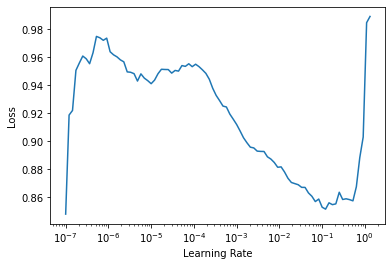

In [38]:
learn.lr_find()

In [39]:
lr = 3e-2

In [40]:
learn.fine_tune(5, lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.721055,0.529063,0.735727,00:03


epoch,train_loss,valid_loss,accuracy,time
0,0.583542,0.548861,0.740730,00:04
1,0.487256,0.504226,0.761036,00:04
2,0.362967,0.567076,0.771336,00:04
3,0.221590,0.786282,0.771630,00:04
4,0.143732,0.798016,0.776339,00:04


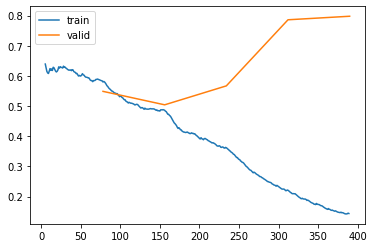

In [41]:
learn.recorder.plot_loss()